In [14]:
# 取り敢えずmnistで試す（CPU上での実行を想定しているため）
from chainer import Chain, Variable, optimizers, iterators, datasets, training
from chainer.training import extensions
from chainer.datasets import mnist
import chainer.functions as F
import chainer.links as L
import chainer

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

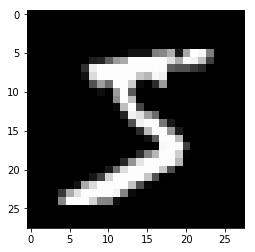

In [22]:
train, test = mnist.get_mnist(withlabel = False)
train = (train - 0.5) / 0.5
train = train.reshape(train.shape[0], 28, 28)
plt.imshow(train[0], cmap = 'gray')
batchsize = 64
dis_itr = iterators.SerialIterator(train[:1000], batchsize)

In [23]:
class Generator(Chain):
    
    def __init__(self):
        super(Generator, self).__init__()
        with self.init_scope():
            self.fc1 = L.Linear(100, 1024)
            self.fc2 = L.Linear(1024, 128 * 7 * 7)
            self.dc3 = L.Deconvolution2D(128, 64, 4, 2, 1)
            self.dc4 = L.Deconvolution2D(64, 1, 4, 2, 1)
            
            self.bn1 = L.BatchNormalization(1024)
            self.bn2 = L.BatchNormalization(128 * 7 * 7)
            self.bn3 = L.BatchNormalization((64, 14, 14))
    def __call__(self, x):
        h = F.relu(self.bn1(self.fc1(x)))
        h = F.relu(self.bn2(self.fc2(h)))
        h = F.reshape(h, (h.shape[0], 128, 7, 7))
        h = F.relu(self.bn3(self.dc3(h)))
        h = F.tanh(self.dc4(h))
        return h

In [24]:
class Discriminator(Chain):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.cv1 = L.Convolution2D(1, 64, 5, 2)
            self.cv2 = L.Convolution2D(64, 128, 5, 2)
            self.fc3 = L.Linear(None, 256)
            self.fc4 = L.Linear(256, 2)
            
            self.bn1 = L.BatchNormalization((64, 12, 12))
            self.bn2 = L.BatchNormalization((128, 4, 4))
            self.bn3 = L.BatchNormalization(256)
    def __call__(self, x):
        h = F.leaky_relu(self.bn1(self.cv1(x)), 0.2)
        h = F.leaky_relu(self.bn2(self.cv2(h)), 0.2)
        h = F.leaky_relu(self.bn3(self.fc3(h)), 0.2)
        h = F.dropout(h, 0.5)
        h = self.fc4(h)
        return h

In [27]:
model_gen = Generator()
model_dis = Discriminator()
opt_gen = optimizers.Adam(alpha = 2e-4, beta1 = 0.5)
opt_dis = optimizers.Adam(alpha = 2e-4, beta1 = 0.5)
opt_gen.setup(model_gen)
opt_dis.setup(model_dis)
opt_gen.add_hook(chainer.optimizer.WeightDecay(0.00001))
opt_dis.add_hook(chainer.optimizer.WeightDecay(0.00001))

In [28]:
max_epoch = 20

GENERATED_IMAGE_PATH = 'generated_images/'
if not os.path.exists(GENERATED_IMAGE_PATH):
    os.mkdir(GENERATED_IMAGE_PATH)

In [29]:
def train():
    dis_itr.epoch = 0
    while dis_itr.epoch < max_epoch:
        real_images = np.array(dis_itr.next()).reshape(batchsize, 1, 28, 28)
        y = model_dis(real_images)
        loss_dis = F.softmax_cross_entropy(y, Variable(np.zeros(batchsize).astype(np.int32)))
        # model_dis.cleargrads()
        # loss.backward()
        # opt_dis.update()
        
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batchsize)]).astype(np.float32)
        generated_images = model_gen(noise)
        y = model_dis(generated_images)
        loss_dis += F.softmax_cross_entropy(y, Variable(np.ones(batchsize).astype(np.int32)))
        model_dis.cleargrads()
        loss_dis.backward()
        opt_dis.update()
        
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batchsize)]).astype(np.float32)
        y = model_dis(model_gen(noise))
        loss_gen = F.softmax_cross_entropy(y, Variable(np.zeros(batchsize).astype(np.int32)))
        model_gen.cleargrads()
        loss_gen.backward()
        opt_gen.update()
        
        if dis_itr.is_new_epoch:
            print("epoch:", dis_itr.epoch)
            print("loss_dis:", loss_dis, "  loss_gen:", loss_gen)
            for n,image in enumerate(generated_images):
                image = image.data*127.5 + 127.5
                Image.fromarray(image.astype(np.uint8).reshape(28, 28)) \
                                                      .save(GENERATED_IMAGE_PATH+"%03d_%03d.png" % (dis_itr.epoch, n))

In [30]:
train()

epoch: 1
loss_dis: variable(1.6445675)   loss_gen: variable(0.7310108)
epoch: 2
loss_dis: variable(1.648934)   loss_gen: variable(0.8207296)
epoch: 3
loss_dis: variable(1.4673563)   loss_gen: variable(0.84240323)
epoch: 4
loss_dis: variable(1.5874603)   loss_gen: variable(0.8009055)
epoch: 5
loss_dis: variable(1.486813)   loss_gen: variable(0.87824523)
epoch: 6
loss_dis: variable(1.4244695)   loss_gen: variable(0.862131)


KeyboardInterrupt: 

variable([[0.49377477],
          [0.48071706],
          [0.67757636],
          [0.07900268],
          [0.14918995],
          [0.51163566],
          [0.20375797],
          [0.6071904 ],
          [0.50590307],
          [0.70900935],
          [0.21331999],
          [0.8724573 ],
          [0.5203341 ],
          [0.15140301],
          [0.50248003],
          [0.6672561 ],
          [0.7558276 ],
          [0.06742936],
          [0.5814702 ],
          [0.35230193],
          [0.2636234 ],
          [0.1104241 ],
          [0.65618205],
          [0.6456479 ],
          [0.17895073],
          [0.49548286],
          [0.71476763],
          [0.68162894],
          [0.27497268],
          [0.87704116],
          [0.46291363],
          [0.3266731 ],
          [0.4282906 ],
          [0.42889568],
          [0.48864678],
          [0.10695511],
          [0.6900749 ],
          [0.88779914],
          [0.57001734],
          [0.55827165],
          [0.21440238],
          [0.414

In [73]:
a, b = mnist.get_mnist()


In [77]:
from chainer.dataset import concat_examples
x, t = concat_examples(a)

In [91]:
x = x.reshape(60000,1,28,28)
t.shape
t_1 = t[:32]

In [89]:
y_1 = model_dis(x[:32])

In [97]:
F.sigmoid_cross_entropy(y_1.reshape(32,), t_1)

variable(-1.1475618)

In [152]:
noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batchsize)]).astype(np.float32)
generated_images = model_gen(noise)
y = model_dis(generated_images)
loss = F.sigmoid_cross_entropy(y.reshape(batchsize,), Variable(np.zeros(batchsize).astype(np.int32)))

In [153]:
print(loss)

variable(0.9552179)
